In [1]:
#JAI GANESH DEVA!!!

In [148]:
import pandas as pd
import numpy as np
import os
import nltk
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import word_tokenize,sent_tokenize
import nltk.data
import string
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from gensim import corpora, models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

In [3]:
from collections import Counter
import pickle
import numpy as np
from textblob import TextBlob
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from scipy.sparse import csr_matrix, hstack
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve

In [4]:
%matplotlib  inline
import matplotlib
import matplotlib.pyplot as plt

In [5]:
#os.chdir("/Users/akhilakotapati/Downloads/Project/FinalDataSet/")

In [6]:
Sar=pd.read_csv("training_balanced.csv",header=None)

In [7]:
tes = pd.read_csv("test_balanced.csv",header=None)

In [8]:
# Punctuation removal

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [9]:
def preprocess(df):
    df.columns=['index','commentid','label','author','created_utc','date','downs','score','subreddit','text','ups']
    df=df.drop('index', axis=1)
    df['text1']=df['text'].copy()
    df=df.drop(Sar.index[0])
    df=df.reset_index(drop=True)
    #Lowercase
    df.text1=df.text1.astype(str).str.lower()
    #Punctuation removal
    df["text1"] = df['text1'].str.replace('[^\w\s]','')
    #Tokenization
    df.text1=df.apply(lambda row: word_tokenize(row['text1']),axis=1)
    #Stop Words Removal
    stop_words = stopwords.words("english")
    df["text1"]=df["text1"].apply(lambda x: [word for word in x if word not in stop_words])
    return df
    

In [10]:
Sar = preprocess(Sar)
tes = preprocess(tes)

In [17]:
def remove_url(text):
    
    ptrn = "((http|ftp|https):\/\/)?([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w.,@?^=%&:\/~+#-])?"
    return re.sub(ptrn, "", text)

def remove_stopwords(text):
    
    stop_words = set(stopwords.words("english"))
    tokens = nltk.word_tokenize(text)
    stop_rem = " ".join([w for w in tokens if not w in stop_words])
    return stop_rem



#Divide the text as per given n-gram
def text_divide(text, n):
   
    token = nltk.word_tokenize(text)
    spilt_len = len(text) / n
    op = []
    x = 0
    for i in range(n):
        str_list = token[x:int(x+spilt_len)]
        string = " ".join(str_list)
        op.append(string)
        x = int(x+spilt_len)
    return op



#Finding the sentiment of unigram, bigram and trigram of each comment. Sentiment means finding polarity.
def get_sentiment(arr):
    
    n = len(arr)
    polar = []
    for i in range(n):
        analysis = TextBlob(arr[i])
        polar.append(analysis.sentiment.polarity)
    return polar

def find_sent(arr):
    
    #n = len(arr)
    op = np.empty((len(arr), 6))
    for i in range(len(arr)):
        analysis = TextBlob(arr[i])
        uni_sent = analysis.sentiment.polarity
        string_list = text_divide(arr[i], 2)
        bi_sent = get_sentiment(string_list)
        string_list = text_divide(arr[i], 3)
        tri_sent = get_sentiment(string_list)
        op[i] = [uni_sent, bi_sent[0], bi_sent[1], tri_sent[0], tri_sent[1], tri_sent[2]]
    return op



#POS tags
def pos_tag(text):
    
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    counts = Counter(tag for word, tag in tags)
    total = sum(counts.values())
    return dict((word, float(count)/total) for word, count in counts.items())

def get_pos(arr):
    
    out = np.array([])
    for i in range(len(arr)):
        postags = pos_tag(arr[i])
        out = np.append(out, postags)
    return out

In [12]:
#Creating a column for data with all the preprocessing steps except for tokenization.
Sar['data']=Sar['text'].copy()
Sar.data=Sar.data.astype(str).str.lower()
Sar["data"] = Sar['data'].apply(remove_punctuations)

In [13]:
tes['data']=tes['text'].copy()
tes.data=tes.data.astype(str).str.lower()
tes["data"] = tes['data'].str.replace('[^\w\s]','')

In [14]:
traindata = Sar.copy()
testdata= tes.copy()

In [15]:
X_train = np.array([])
y_train = np.array([])
for i in range(len(traindata.data)):
    data_clean = remove_url(str(traindata.data[i]))
    data_clean = remove_stopwords(data_clean)
    X_train = np.append(X_train, data_clean)
    if traindata.label[i] == '0':
        y_train = np.append(y_train, 'not_sarcastic')
    else:
        y_train = np.append(y_train, 'sarcastic')
        
X_test = np.array([])
y_test = np.array([])
for i in range(len(testdata.data)):
    test_clean = remove_url(str(testdata.data[i]))
    test_clean = remove_stopwords(test_clean)
    X_test = np.append(X_test, test_clean)
    if testdata.label[i] == '0':
        y_test = np.append(y_test, 'notsarcastic')
    else:
        y_test = np.append(y_test, 'sarcastic')

In [18]:
#Finding sentiment of the comment- getting unigrams, bigrams, trigrams
sentiment_train = csr_matrix(find_sent(X_train))
sentiment_test = csr_matrix(find_sent(X_test))

In [19]:
# Finding TF-IDF features of training and testing set
def tokenize(text):
    """returns tokens"""
    tokens = nltk.word_tokenize(text)
    #stems = stem_tokens(tokens, stemmer)
    return tokens

tfidf = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1, 3), min_df=0.05)
tfs_train = tfidf.fit_transform(X_train)
tfs_test = tfidf.transform(X_test)

In [29]:
#Lowercase
#trf = Sar.copy()
#tf = tes.copy()
def wvec(df):
    df.text1=df.text1.astype(str).str.lower()
    #Punctuation removal
    df["text1"] = df['text1'].str.replace('[^\w\s]','')
    #Tokenization
    df.text1=df.apply(lambda row: word_tokenize(row['text1']),axis=1)
    return df
trf = wvec(Sar)
tf = wvec(tes)

In [30]:
a = trf['text1'].values
b = tf['text1'].values
two = np.concatenate((a, b), axis=0)

# Word2Vec

In [31]:
#word2vec
sar_vec = Word2Vec(two, size=50, window=5, min_count=1, workers=4,hs=0,negative=10,sg=1)

In [78]:
trf

,commentid,label,author,created_utc,date,downs,score,subreddit,text,ups,...,data,word_vec,no_of_words,no_of_uppercase_letters,polarity,subjectivity,no_of_!,no_of_dots,no_of_?,no_of_single_quotes
0,c06zzxs,1,feliandrade,1231810289,2009-01,0,9,politics,damn jews,9,...,damn jews,"[-0.138873, -0.0745754, 0.115186, -0.616195, -...",2,0,0.000000,0.000000,0,0,0,0
1,c0702jh,0,njharman,1231817525,2009-01,0,17,politics,"It's ok, we **can read** all by ourselves.",17,...,its ok we can read all by ourselves,"[-0.116005, -0.10334, 0.13428, -0.618804, -0.0...",8,1,0.500000,0.500000,0,1,0,1
2,c074g8n,0,invalid_user_name,1232317207,2009-01,0,3,politics,If there is anything reddit hates more than th...,3,...,if there is anything reddit hates more than th...,"[-0.0398084, -0.186416, 0.208377, -0.764143, 0...",25,9,0.392857,0.517857,0,1,0,0
3,c074j16,1,krizo,1232325755,2009-01,0,3,politics,"Yeah, that's not a biased source at all.",3,...,yeah thats not a biased source at all,"[0.0006816, -0.233984, 0.156841, -0.70589, -0....",8,1,0.000000,0.000000,0,1,0,1
4,c078hoz,0,TheBlueberryPirate,1232750515,2009-01,0,27,politics,It's not uncommon for a politician to put fort...,27,...,its not uncommon for a politician to put forth...,"[-0.0764445, -0.0163182, 0.0608462, -0.304052,...",44,1,0.143750,0.623438,0,1,0,1
5,c078qk0,1,frogking,1232778014,2009-01,0,2,politics,"values, as in capitalism .. there is good mone...",2,...,values as in capitalism there is good money i...,"[-0.157753, -0.0371717, 0.135048, -0.61713, -0...",13,0,0.700000,0.600000,0,4,0,0
6,c07e0iu,1,kingkilr,1233427018,2009-01,0,20,politics,That socialist bastard,20,...,that socialist bastard,"[-0.160934, -0.0562907, 0.136439, -0.603031, -...",3,1,0.000000,0.000000,0,0,0,0
7,c07e0z1,0,Jasper1984,1233428330,2009-01,0,-12,politics,[citation needed],-12,...,citation needed,"[-0.083583, -0.0242578, 0.0674544, -0.284515, ...",2,0,0.000000,0.000000,0,0,0,0
8,c07jfvv,1,Erobern,1234070581,2009-02,0,6,politics,"Oh right, *both* wars were just jewish conspir...",6,...,oh right both wars were just jewish conspiraci...,"[-0.0549537, -0.287564, 0.0645597, -0.774101, ...",14,2,0.142857,0.267857,0,1,0,0
9,c07jy05,0,five5,1234150201,2009-02,0,1,politics,"i know this seems strange but, what if he was ...",1,...,i know this seems strange but what if he was t...,"[0.0225833, -0.294829, 0.174513, -0.820213, 0....",13,0,-0.050000,0.150000,0,0,0,0


In [91]:
#Sar = pd.read_csv("Sar_c.csv")

In [102]:
#tes = pd.read_csv("tes_c.csv")

In [92]:
len(sar_vec.wv.vocab)

14664

In [118]:
#sar_vec = gensim.models.KeyedVectors.load_word2vec_format('./sarp_load.bin', binary=True)

In [98]:
# Assigning word vectors to the corresponding words in the dataframe.

def words(arr):
    for i in range(len(arr)):
        if arr[i] in sar_vec.wv.vocab:
            return sar_vec[arr[i]]
        


In [99]:
#trf["word_vec"]=""
tw_tr=[]
for i in range(len(Sar)):
    #print("i value in vec_train =",i)
    tw_tr = np.append(tw_tr, words(Sar.text1[i]))
    #trf.word_vec[i]=words(trf.text1[i])

In [110]:
len(tw_te)
#len(trf.text[786])

142000

In [101]:
two_tr = np.reshape(tw_tr, (13668,50))

In [109]:
tw_te=[]
for i in range(len(tes)):
    #print("i value in vec_train =",i)
    tw_te = np.append(tw_te, words(tes.text1[i]))

In [112]:
two_te = np.reshape(tw_te, (2840,50))

# LDA

In [ ]:
def get_topic_features(col):
    
   
    colname = col.name
    col = col.astype(str).apply(lambda x:x.split())
    dictionary = corpora.Dictionary(col)
    corpus = [dictionary.doc2bow(text) for text in col]
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    lda = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=100, passes=2, iterations=50)
    print(lda.print_topics(-1))
    
    
    # get topic distribution for doc
    def get_topics(words): return dict(lda[dictionary.doc2bow(words)])
    topics_df = pd.DataFrame(col.apply(get_topics).tolist()).fillna(0.001)
    topics_df.columns = ['topic_'+str(cn)+'_'+colname for cn in topics_df.columns]
    return topics_df

In [55]:
a = Sar['data'].values
b = tes['data'].values
wo = np.concatenate((a, b), axis=0)

In [56]:
# Finding TF-IDF features of training and testing set
def tokenize(text):
    """returns tokens"""
    tokens = nltk.word_tokenize(text)
    #stems = stem_tokens(tokens, stemmer)
    return tokens
tfidfw = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1, 3), min_df=0.05,lowercase=False)
tfs_whole = tfidfw.fit(wo)

tfs_wo_tr = tfidfw.transform(Sar['data'])
tfs_wo_te = tfidfw.transform(tes['data'])


In [57]:
#Count Vectorizer
vecto = CountVectorizer(ngram_range=(1,3))
BOW_wo = vecto.fit(wo)
C_tr=BOW_wo.transform(Sar['data'])
C_te = BOW_wo.transform(tes['data'])

In [59]:
# Initialize Dictionary Vectorizer
vecy = DictVectorizer()

# Finding Parts of Speech Features of training and testing set
g=get_pos(wo)
g1=get_pos(Sar['data'])
g2=get_pos(tes['data'])
POS_wo = vecy.fit(g)
pos_train = POS_wo.transform(g1)
pos_test = POS_wo.transform(g2)

In [60]:
# Initializing LDA
lda = LatentDirichletAllocation(n_components=50, learning_method='online')

#Finding Topic Features of training and testing set
tfs_lda = tfidfw.fit_transform(wo)
TP = lda.fit(tfs_lda)
topic_train = TP.transform(tfs_wo_tr)
topic_test = TP.transform(tfs_wo_te)

In [126]:
#Sentiment - polarity, subjectivity
from textblob import TextBlob
def senti(d):
    e = TextBlob(d).sentiment
    
    return e

po_tr = []
for i in range(len(Sar)):
    po_tr = np.append(po_tr,senti(Sar.data[i]))
    
pol_tr = np.reshape(po_tr, (13668,2))

po_te = []
for i in range(len(tes)):
    po_te = np.append(po_te,senti(tes.data[i]))
    
pol_te = np.reshape(po_te, (2840,2))

In [61]:
def Feature_Extraction(datafraame):
    
    
    datafraame["no_of_words"] = datafraame["text"].apply(nwords)
    
    datafraame["no_of_uppercase_letters"] = datafraame["text"].apply(uppercase)
    
    datafraame[['polarity', 'subjectivity']] = datafraame['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
    
    datafraame["no_of_!"] = datafraame["text"].apply(ex)
    
    datafraame["no_of_dots"] = datafraame["text"].apply(dot)
    
    datafraame["no_of_?"] = datafraame["text"].apply(ques)
    
    datafraame["no_of_single_quotes"] = datafraame["text"].apply(quot)
    
    return datafraame




def quot(d):
    quot = []
    for _ in d:
        if _ in "'":
            quot.append(_)
    return len(quot)



def ques(d):
    ques = []
    for _ in d:
        if _ in "?":
            ques.append(_)
    return len(ques)

def dot(d):
    dot = []
    for _ in d:
        if _ in ".":
            dot.append(_)
    return len(dot)


def ex(d):
    exl = []
    for _ in d:
        if _ in "!":
            exl.append(_)
    return len(exl)


def uppercase(d):
    up = []
    for _ in d:
        if _.isupper() == True:
            up.append(_)
    return len(up)


def nwords(d):
    
    return len(d.split(" "))



In [62]:
#Basic Features
nume_tr=Feature_Extraction(Sar)
nume_te=Feature_Extraction(tes)

In [63]:
nume_tr_arr = nume_tr.as_matrix(columns=['no_of_words','polarity', 'subjectivity', 'no_of_uppercase_letters', 'no_of_!','no_of_dots', 'no_of_?', 'no_of_single_quotes'])
nume_te_arr = nume_te.as_matrix(columns=['no_of_words','polarity', 'subjectivity', 'no_of_uppercase_letters', 'no_of_!','no_of_dots', 'no_of_?', 'no_of_single_quotes'])
na_tr = nume_tr.as_matrix(columns=['no_of_words', 'subjectivity', 'no_of_uppercase_letters', 'no_of_!','no_of_dots', 'no_of_?', 'no_of_single_quotes'])
na_te = nume_te.as_matrix(columns=['no_of_words', 'subjectivity', 'no_of_uppercase_letters', 'no_of_!','no_of_dots', 'no_of_?', 'no_of_single_quotes'])

In [115]:
#y_train = np.load('y-train-bal.npy')
#y_test = np.load('y-test-bal.npy')

# Using Word2Vec

In [116]:
# SVM Model with Gaussian Kernel
svm_clf = SVC(C=500, gamma= 0.0001, kernel='rbf')
svm_clf = svm_clf.fit(two_tr, y_train)

predict = svm_clf.predict(two_te)

svm_score = accuracy_score(y_test, predict)
print('SVM = ', svm_score)

SVM =  0.527112676056


In [119]:
y_truewd, y_predwd = y_test, predict
print(classification_report(y_truewd, y_predwd))
print()

              precision    recall  f1-score   support

notsarcastic       0.54      0.34      0.42      1420
   sarcastic       0.52      0.71      0.60      1420

 avg / total       0.53      0.53      0.51      2840




In [120]:
y_pdwd = []
for i in range(len(y_predwd)):
    if y_predwd[i] == 'sarcastic':
        y_pdwd = np.append(y_pdwd,1)
    else:
        y_pdwd = np.append(y_pdwd,0)

In [123]:
print("Support Vector Machine:")
print("Precision:",precision_score(labe, y_pdwd))
print("Recall   :",recall_score(labe, y_pdwd))
print("F1 score :",f1_score(labe, y_pdwd))

Support Vector Machine:
Precision: 0.519835136528
Recall   : 0.710563380282
F1 score : 0.600416542696


# Using Sentiment

In [129]:
# SVM Model with Gaussian Kernel
svm_clfs = SVC(C=500, gamma= 0.0001, kernel='rbf')
svm_clfs = svm_clfs.fit(na_tr, y_train)

predicts = svm_clfs.predict(na_te)

svm_score = accuracy_score(y_test, predicts)
print('SVM = ', svm_score)

SVM =  0.569014084507


In [130]:
y_trues, y_preds = y_test, predicts
print(classification_report(y_trues, y_preds))
print()

              precision    recall  f1-score   support

notsarcastic       0.54      0.90      0.68      1420
   sarcastic       0.71      0.24      0.35      1420

 avg / total       0.62      0.57      0.52      2840




In [131]:
y_pds = []
for i in range(len(y_preds)):
    if y_preds[i] == 'sarcastic':
        y_pds = np.append(y_pds,1)
    else:
        y_pds = np.append(y_pds,0)

In [132]:
print("Support Vector Machine:")
print("Precision:",precision_score(labe, y_pds))
print("Recall   :",recall_score(labe, y_pds))
print("F1 score :",f1_score(labe, y_pds))

Support Vector Machine:
Precision: 0.706751054852
Recall   : 0.235915492958
F1 score : 0.353748680042


# Using Punctuation based features

In [133]:
# SVM Model with Gaussian Kernel
svm_clfnu = SVC(C=500, gamma= 0.0001, kernel='rbf')
svm_clfnu = svm_clfnu.fit(na_tr, y_train)

predictnu = svm_clfnu.predict(na_te)

svm_scorenu = accuracy_score(y_test, predictnu)
print('SVM = ', svm_scorenu)

SVM =  0.569014084507


In [134]:
y_truenu, y_prednu = y_test, predictnu
print(classification_report(y_truenu, y_prednu))
print()

              precision    recall  f1-score   support

notsarcastic       0.54      0.90      0.68      1420
   sarcastic       0.71      0.24      0.35      1420

 avg / total       0.62      0.57      0.52      2840




In [137]:
y_pdnu = []
for i in range(len(y_prednu)):
    if y_prednu[i] == 'sarcastic':
        y_pdnu = np.append(y_pdnu,1)
    else:
        y_pdnu = np.append(y_pdnu,0)

In [138]:
print("Support Vector Machine:")
print("Precision:",precision_score(labe, y_pdnu))
print("Recall   :",recall_score(labe, y_pdnu))
print("F1 score :",f1_score(labe, y_pdnu))

Support Vector Machine:
Precision: 0.706751054852
Recall   : 0.235915492958
F1 score : 0.353748680042


In [139]:
lab = []
for i in range(len(y_train)):
    if y_train[i] == 'sarcastic':
        lab = np.append(lab,1)
    else:
        lab = np.append(lab,0)
        
        
labe = []
for i in range(len(y_test)):
    if y_test[i] == 'sarcastic':
        labe = np.append(labe,1)
    else:
        labe = np.append(labe,0)

In [140]:
# Stacking together all features for training and testing set
o_train = hstack([sentiment_train,two_tr, tfs_wo_tr, pos_train,C_tr,nume_tr_arr,topic_train])
o_test = hstack([sentiment_test,two_te, tfs_wo_te, pos_test,C_te,nume_te_arr,topic_test])

# Grid Search

In [ ]:

param_grid = [
  {'C': [0.01, 0.05, 0.1, 0.5, 100,150, 700,800,1000], 'kernel': ['linear']},
     
  {'C': [0.1, 0.5,200,500, 550, 600,700,800,1000], 'gamma': [0.1,0.01,0.001, 0.0001], 'kernel': ['rbf']},
 ]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
svm_g=SVC()
clf = GridSearchCV(svm_g, param_grid, scoring='%s_macro' % score)
clf = clf.fit(o_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()

# Naive Bayes

In [141]:
# Stacking together all features for training and testing set for naive bayes
N_train = hstack([tfs_wo_tr,pos_train,na_tr,C_tr])
N_test = hstack([ tfs_wo_te, pos_test,na_te,C_te])

In [142]:
nb= MultinomialNB()
nb= nb.fit(N_train, y_train)

predictb = nb.predict(N_test)

nb_score = accuracy_score(y_test, predictb)
print('Naive Bayes = ', nb_score)

Naive Bayes =  0.685915492958


In [145]:
y_trueb, y_predb = y_test, predictb
print(classification_report(y_trueb, y_predb))
print()
print("confusion matrix:")
print()
print(confusion_matrix(y_trueb, y_predb))

y_pdb = []
for i in range(len(y_predb)):
    if y_predb[i] == 'sarcastic':
        y_pdb = np.append(y_pdb,1)
    else:
        y_pdb = np.append(y_pdb,0)

              precision    recall  f1-score   support

notsarcastic       0.71      0.63      0.67      1420
   sarcastic       0.67      0.75      0.70      1420

 avg / total       0.69      0.69      0.68      2840


confusion matrix:

[[ 888  532]
 [ 360 1060]]


In [146]:
y_scores = cross_val_predict(nb,N_train, y_train,cv=3)

y_scb = []
for i in range(len(y_scores)):
    if y_scores[i] == 'sarcastic':
        y_scb = np.append(y_scb,1)
    else:
        y_scb = np.append(y_scb,0)
        
print("Naive Bayes:")
print("Precision:",precision_score(labe, y_pdb))
print("Recall   :",recall_score(labe, y_pdb))
print("F1 score :",f1_score(labe, y_pdb))

Naive Bayes:
Precision: 0.665829145729
Recall   : 0.746478873239
F1 score : 0.70385126162


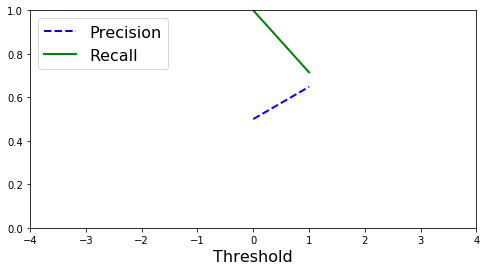

In [149]:
precisions, recalls, thresholds = precision_recall_curve(lab, y_scb)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-4, 4])
plt.show()

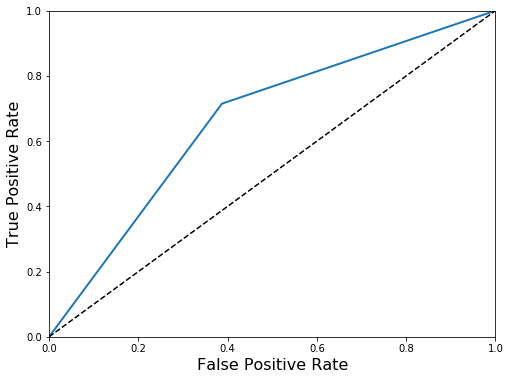

In [150]:
fpr, tpr, thresholds = roc_curve(lab, y_scb)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

# SVM on overall data

In [151]:
# SVM Model with Gaussian Kernel
svm_clf1 = SVC(C=600, gamma= 0.0001, kernel='rbf')
svm_clf1 = svm_clf1.fit(o_train, y_train)

predict1 = svm_clf1.predict(o_test)

svm_score1 = accuracy_score(y_test, predict1)
print('SVM = ', svm_score1)

SVM =  0.693661971831


In [152]:
y_true, y_pred = y_test, svm_clf1.predict(o_test)
print(classification_report(y_true, y_pred))
print()

              precision    recall  f1-score   support

notsarcastic       0.68      0.72      0.70      1420
   sarcastic       0.71      0.66      0.68      1420

 avg / total       0.69      0.69      0.69      2840




In [153]:
y_true, y_pred = y_test, svm_clf1.predict(o_test)
print("confusion matrix:")
print()
print(confusion_matrix(y_trueb, y_predb))

confusion matrix:

[[ 888  532]
 [ 360 1060]]


In [154]:
y_pd = []
for i in range(len(y_pred)):
    if y_pred[i] == 'sarcastic':
        y_pd = np.append(y_pd,1)
    else:
        y_pd = np.append(y_pd,0)

In [155]:
print("Support Vector Machine:")
print("Precision:",precision_score(labe, y_pd))
print("Recall   :",recall_score(labe, y_pd))
print("F1 score :",f1_score(labe, y_pd))

Support Vector Machine:
Precision: 0.70553064275
Recall   : 0.664788732394
F1 score : 0.684554024656


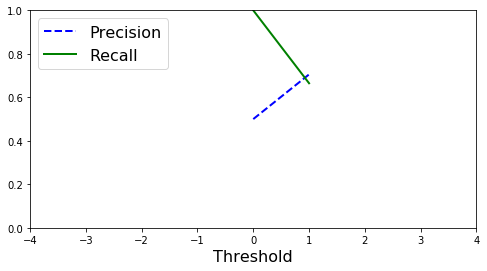

In [156]:
precisions, recalls, thresholds = precision_recall_curve(labe, y_pd)
def plot_prec_recl_thresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_prec_recl_thresh(precisions, recalls, thresholds)
plt.xlim([-4, 4])
plt.show()

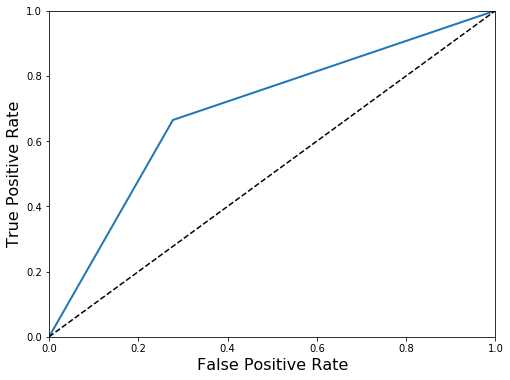

In [157]:
fpr, tpr, thresholds = roc_curve(labe, y_pd)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)